In [2]:
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression
import numpy as np
from hmmlearn import hmm
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import statsmodels.api as sm

In [3]:
# def  model_function(train_data -> np.array, num_of_predictions -> int):

# 	Return prediction 

In [4]:
googl = yf.download("GOOGL", start="2018-01-01", end="2021-12-31").reset_index()
googl.Date = pd.to_datetime(googl.Date)

[*********************100%***********************]  1 of 1 completed


In [5]:
googl

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,1053.020020,1075.979980,1053.020020,1073.209961,1073.209961,1588300
1,2018-01-03,1073.930054,1096.099976,1073.430054,1091.520020,1091.520020,1565900
2,2018-01-04,1097.089966,1104.079956,1094.260010,1095.760010,1095.760010,1302600
3,2018-01-05,1103.449951,1113.579956,1101.800049,1110.290039,1110.290039,1512500
4,2018-01-08,1111.000000,1119.160034,1110.000000,1114.209961,1114.209961,1232200
...,...,...,...,...,...,...,...
993,2021-12-10,2974.000000,2979.550049,2934.080078,2960.030029,2960.030029,1222900
994,2021-12-13,2955.629883,2959.399902,2910.350098,2916.530029,2916.530029,1353500
995,2021-12-14,2879.360107,2889.600098,2824.300049,2878.139893,2878.139893,1922300
996,2021-12-15,2868.179932,2934.419922,2833.560059,2928.820068,2928.820068,1816300


In [6]:
daily_return = googl['Return'] = np.log(googl.Close /googl.Close.shift(-1)).dropna()
#(np.log(googl.Close /googl.Close.shift(-1))).dropna()
# np.log(googl.Close.pct_change()).dropna()

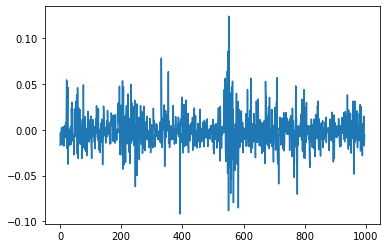

In [7]:
plt.plot(daily_return)

In [8]:
googl[googl.Date>='2021-01-01']

,Date,Open,High,Low,Close,Adj Close,Volume,Return
756,2021-01-04,1760.000000,1762.489990,1707.140015,1726.130005,1726.130005,1866200,-0.008032
757,2021-01-05,1725.089966,1746.829956,1716.900024,1740.050049,1740.050049,1018000,0.009917
758,2021-01-06,1700.260010,1743.969971,1696.099976,1722.880005,1722.880005,2329400,-0.029431
759,2021-01-07,1726.760010,1777.819946,1726.760010,1774.339966,1774.339966,2096800,-0.013152
760,2021-01-08,1777.160034,1799.359985,1761.219971,1797.829956,1797.829956,1774200,0.023377
...,...,...,...,...,...,...,...,...
993,2021-12-10,2974.000000,2979.550049,2934.080078,2960.030029,2960.030029,1222900,0.014805
994,2021-12-13,2955.629883,2959.399902,2910.350098,2916.530029,2916.530029,1353500,0.013250
995,2021-12-14,2879.360107,2889.600098,2824.300049,2878.139893,2878.139893,1922300,-0.017455
996,2021-12-15,2868.179932,2934.419922,2833.560059,2928.820068,2928.820068,1816300,-0.006314


In [30]:
train,test = googl[googl.Date<'2021-01-01'].Return,googl[googl.Date>='2021-01-01'].Return
# train,test = daily_return[:2800],daily_return[-238:]

In [31]:
train_np = np.array(train).reshape(-1,1)
test_np = np.array(test[:-1]).reshape(-1,1)

# HMM 

In [51]:
def hmm_prediction_MCMC(train_data,num_of_predictions,num_samples = 10):
    
    hmm_prediction_values_list = []
    hmm_prediction_states_list = []
    #print(train_data)
    for i in range(num_samples):
        #print(i)
        
        hmm_model = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=1000)
        hmm_model.fit(train_data)

        predict_state = hmm_model.predict(train_data)

        hmm_prediction = hmm_model.sample(num_of_predictions,random_state = predict_state[-1])
        hmm_prediction_values = hmm_prediction[0]
        hmm_prediction_states = hmm_prediction[1]
        
        hmm_prediction_values_list.append(hmm_prediction_values) 
        hmm_prediction_states_list.append(hmm_prediction_states)
        
    return hmm_prediction_values_list,hmm_prediction_states_list

In [52]:
value_list, states_list = hmm_prediction_MCMC(train_np,len(test_np))

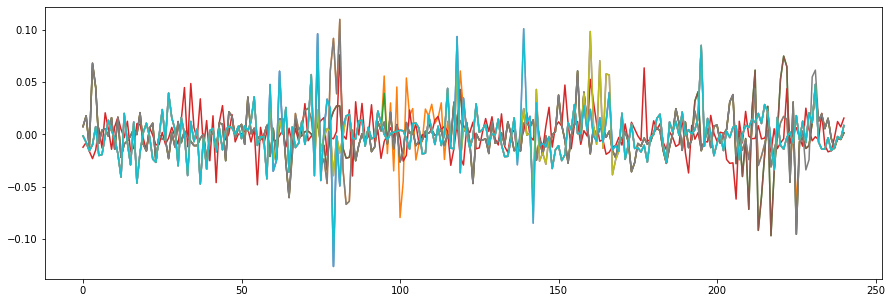

In [54]:
for ele in value_list:
    plt.plot(ele)